<a href="https://colab.research.google.com/github/Ashis-Palai/Segmentation-of-Indian-Traffic-Using-Unet-Model/blob/main/Segmentation_of_Indian_Traffic_Using_Unet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation of Indian Traffic Using Unet Model

In [ ]:
!pip3 install -U segmentation-models

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import segmentation_models as sm
from segmentation_models import Unet
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
tf.keras.backend.set_image_data_format('channels_last')
from segmentation_models.metrics import iou_score
from keras_preprocessing.image import ImageDataGenerator
import imgaug.augmenters as iaa
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"
hiddenimports=['tensorflow.keras.engine.base_layer_v1']



Segmentation Models: using `keras` framework.


# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
    jpg_files = [os.path.join(root, name)
             for root, dirs, files in os.walk(root_dir)
             for name in files
             if name.endswith((".jpg"))]

    jpg_files.sort()


    json_files = [os.path.join(root, name)
             for root, dirs, files in os.walk(root_dir)
             for name in files
             if name.endswith((".json"))]

    json_files.sort()

    data_df = pd.DataFrame(jpg_files,columns=['image'])
    data_df['json'] = json_files

    return data_df

In [ ]:
root_dir = 'data'
data_df = return_file_names_df(root_dir)
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


In [ ]:

def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

#### Compute the unique labels

In [ ]:
def return_unique_labels(data_df):
    unique_labels = []
    for i in data_df['json']:
        f = open(i)
        data = json.load(f)
        label_list=set([i['label'] for i in data['objects']])
        for i in label_list:
            unique_labels.append(i)
        f.close()





    return list(set(unique_labels))

In [ ]:
unique_labels = return_unique_labels(data_df)
len(unique_labels)

40

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    f = open(file)
    data_new = json.load(f)
    w = data_new['imgWidth']
    h = data_new['imgHeight']
    label = []
    pvertex = []
    for i in data_new['objects']:
        label.append(i['label']) 
        pvertex.append(i['polygon'])
    
    vertexlist = []
    for i in pvertex:
        if len(i)>1:
            list_tuple = []
            for j in i:
                list_tuple.append((j[0],j[1]))
        vertexlist.append(list_tuple)

    return w, h, label, vertexlist

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


In [ ]:
w, h, labels, vertexlist = get_poly('data/mask/201/frame0029_gtFine_polygons.json')
print(w,h)

1920 1080


## 4. Creating Image segmentations by drawing set of polygons

In [ ]:
def compute_masks(data_df):
    mask_path_list = []
    for json_path in tqdm(data_df['json']):
        w, h, labels, vertexlist = get_poly(json_path)
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        for i in range(len(vertexlist)):
            img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        filename = json_path.split('/')[2]
        if not os.path.exists('data/output/'+filename):
            os.makedirs('data/output/'+filename)
            file_path = 'data/output/{}/'.format(filename)
        im.save(file_path+json_path.split('/')[3][:-5]+'.png')
        mask_path_list.append(file_path+json_path.split('/')[3][:-5]+'.png')


    data_df['mask'] = mask_path_list 

    
    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:13<00:00, 15.79it/s]


,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [ ]:
data_df.to_csv('preprocessed_data.csv', index=False)

# Task 2: Applying Unet to segment the images

### Task 2.1: Dice loss



1.   **Formulation**

     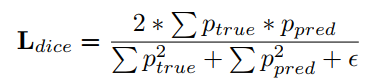List item
    *   where p_true and p_pred are ground truth, predicted pixel values respectively


2.   **Range of the loss function:**
    *   0 is minmum and 1 as maximum (0-1)

3. **Interpretaion of loss function:**
    *  The is the ratio of Intersection to union of two sets (true and pred)
    *  so 0 be the worst score and 1 be the best score for calculating loss with dice loss

4. **How it helps in segmentation:**
    *  Dice Loss is widely used in medical image segmentation tasks to address the data imbalance problem.
    *  a dice score higher than 88%, suggesting a good agreement between predicted and manual Data segmentation









### Task 2.2: Training Unet

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PALAI/ASSIGNMETS/latest_model/preprocessed_data.csv')

In [ ]:

X_train, X_test = train_test_split(data[['image','mask']], test_size=0.1, random_state=42)

In [ ]:
X_train.shape

(3607, 2)

In [ ]:
X_test.shape

(401, 2)

In [ ]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
    
    CLASSES = list((label_clr.keys()))
    
    def __init__(self,data):
        
        self.ids = list(data['mask'])
        # the paths of images
        self.images_fps   = list(data['image'])
        # the paths of segmentation images
        self.masks_fps    = list(data['mask'])
        #giving labels for each class
        self.class_values = list((label_clr.values()))
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(data['image'].values[i], cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image  = cv2.resize(image  ,(256,256) , cv2.INTER_AREA)
        image  = normalize_image(image)
        mask  = cv2.imread(data['mask'].values[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask , (256,256), cv2.INTER_AREA)
        image_masks = [(mask == v) for v in (np.unique(list(label_clr.values()))) ]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        
        if data.shape[0]>3000:
            a = np.random.uniform()
            if a<0.2:
                image = image
                image_mask = image_mask
            elif a<0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            elif a<0.8:
                image = aug5.augment_image(image)
                image_mask = image_mask
            else:
                image = aug6.augment_image(image)
                image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
BATCH_SIZE = 1
CLASSES = list((label_clr.keys()))
train_dataset = Dataset(X_train)
test_dataset  = Dataset(X_test)


train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)



(1, 256, 256, 3)
(1, 256, 256, 21)


In [ ]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [ ]:
width = 256
height = 256
model = Unet(backbone_name='efficientnetb3', encoder_weights = 'imagenet', classes=21, activation='softmax', input_shape=(width,height,3))

44122112/44107200 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 40  1080        ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 40  160         ['stem_conv[0][0]']              
                                )                                                          

In [ ]:
model.load_weights('/content/drive/MyDrive/PALAI/ASSIGNMETS/Segmentation/model_best.h5')

In [ ]:
optim = tf.keras.optimizers.Adam(0.00001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/PALAI/ASSIGNMETS/Segmentation/model_best_new.h5',save_freq='epoch',monitor='val_loss',save_weights_only=True,mode='min', save_best_only=True, \
                                       ),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=7)
]



model.compile(optimizer=optim, loss=focal_loss, metrics=[iou_score], )

In [ ]:
# Training saved model(trained on batches of epochs) for five epochs 
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=5,
                              validation_data=test_dataloader,validation_steps=len(test_dataloader), callbacks=callbacks)

    
    


Epoch 1/5
3607/3607 [==============================] - 517s 143ms/step - loss: 0.4110 - iou_score: 0.6159 - val_loss: 0.5619 - val_iou_score: 0.3842
Epoch 2/5
3607/3607 [==============================] - 517s 143ms/step - loss: 0.4026 - iou_score: 0.6571 - val_loss: 0.5615 - val_iou_score: 0.5473
Epoch 3/5
3607/3607 [==============================] - 513s 142ms/step - loss: 0.4017 - iou_score: 0.6587 - val_loss: 0.5806 - val_iou_score: 0.4185
Epoch 4/5
3607/3607 [==============================] - 513s 142ms/step - loss: 0.4012 - iou_score: 0.5361 - val_loss: 0.5669 - val_iou_score: 0.4463
Epoch 5/5
3607/3607 [==============================] - 512s 142ms/step - loss: 0.3966 - iou_score: 0.4727 - val_loss: 0.5739 - val_iou_score: 0.5514


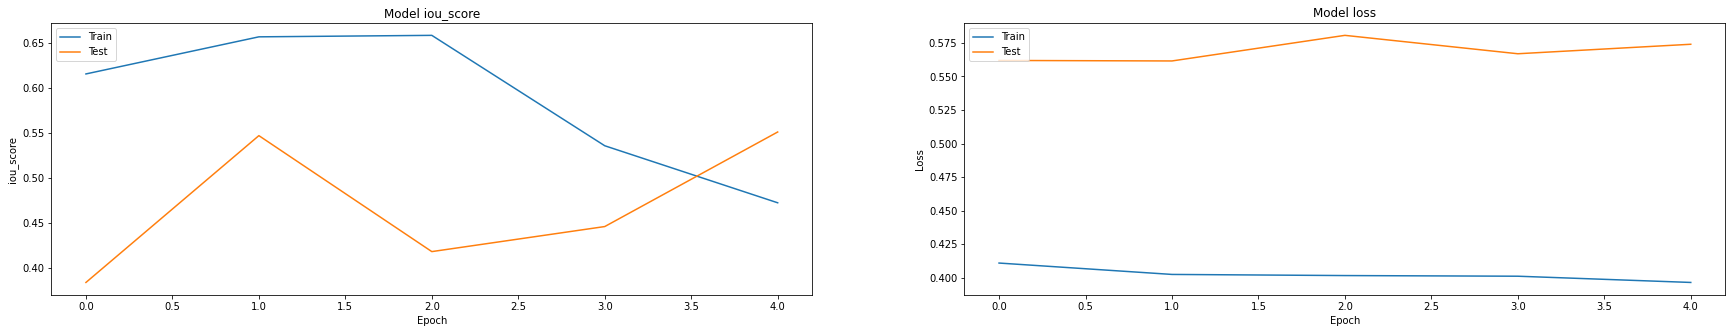

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('/content/drive/MyDrive/PALAI/ASSIGNMETS/Segmentation/model_best_new.h5')

shape (1, 256, 256)


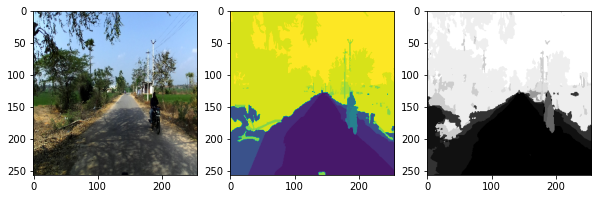

shape (1, 256, 256)


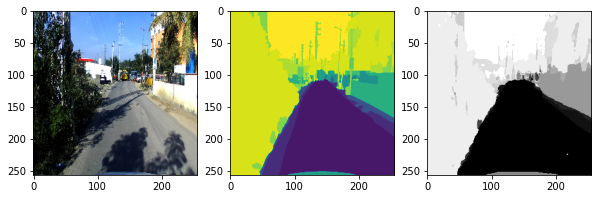

shape (1, 256, 256)


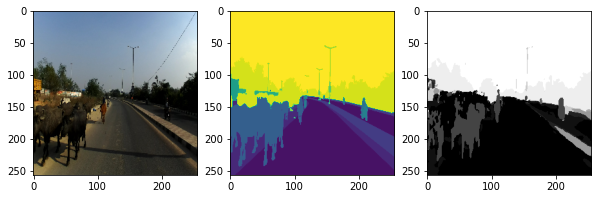

shape (1, 256, 256)


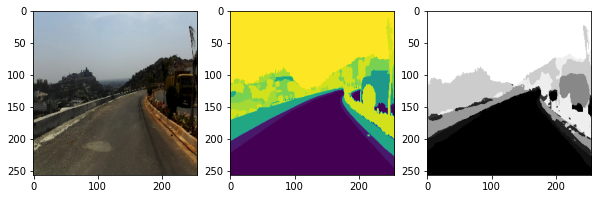

shape (1, 256, 256)


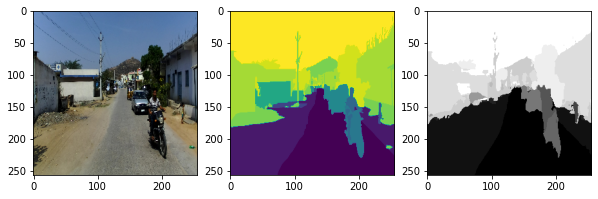

shape (1, 256, 256)


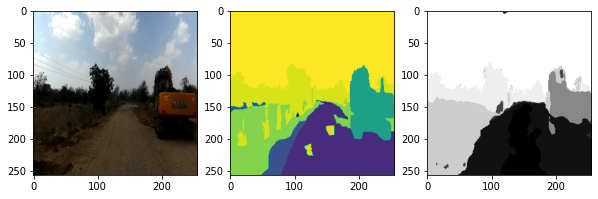

shape (1, 256, 256)


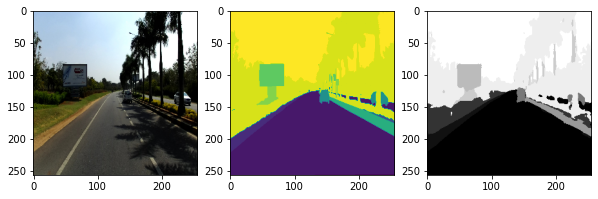

shape (1, 256, 256)


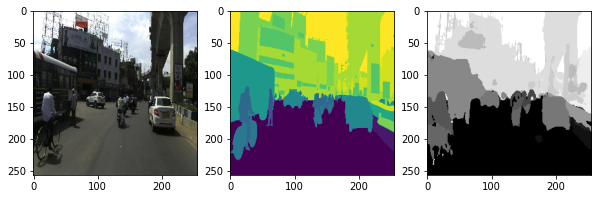

shape (1, 256, 256)


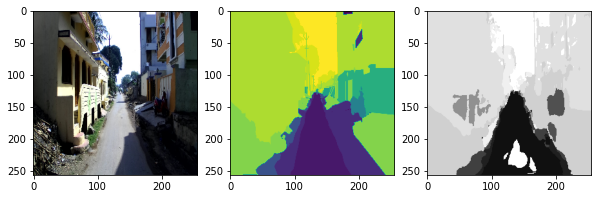

shape (1, 256, 256)


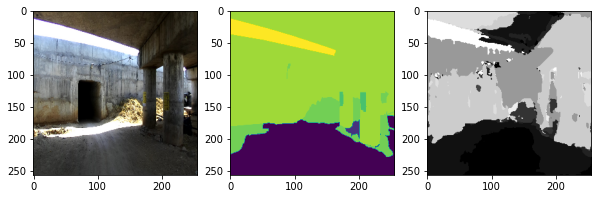

shape (1, 256, 256)


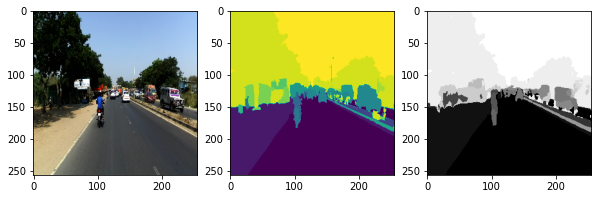

shape (1, 256, 256)


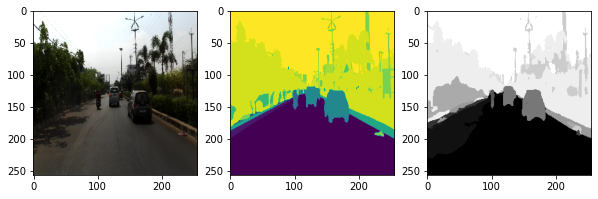

shape (1, 256, 256)


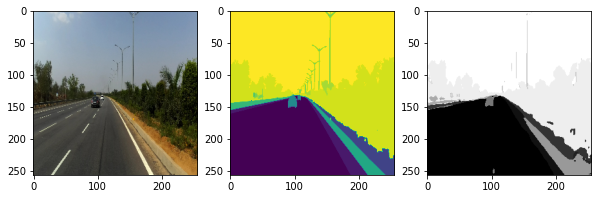

shape (1, 256, 256)


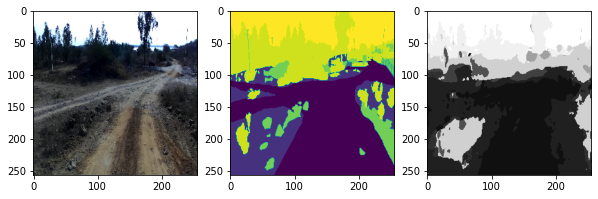

shape (1, 256, 256)


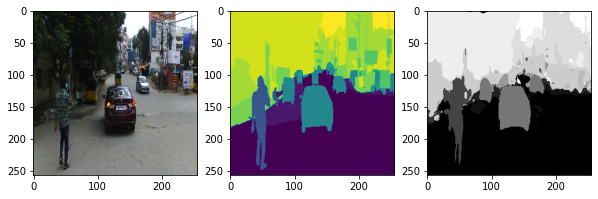

shape (1, 256, 256)


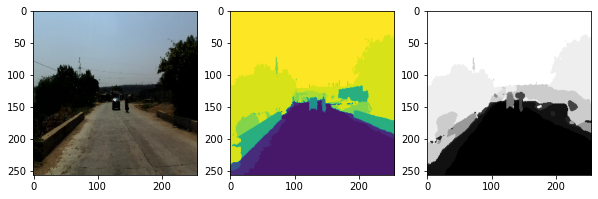

shape (1, 256, 256)


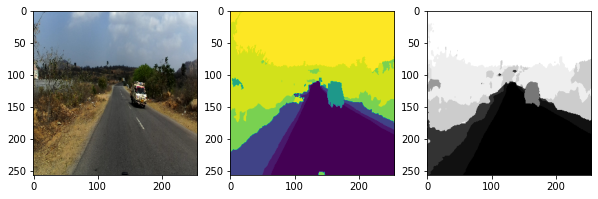

shape (1, 256, 256)


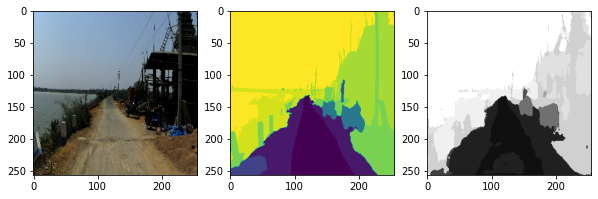

shape (1, 256, 256)


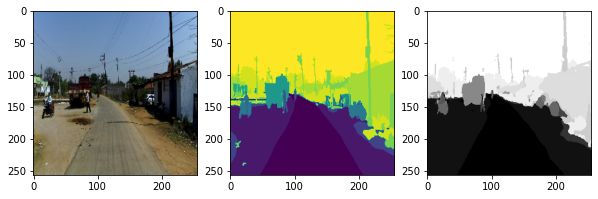

shape (1, 256, 256)


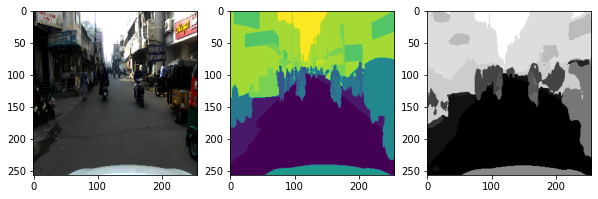

In [ ]:
for i in (X_test[1:21].values):
    
    #original image
    image = cv2.imread(i[0], cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image  = cv2.resize(image  ,(256,256) , cv2.INTER_AREA)
    image  = normalize_image(image)
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    predicted = tf.argmax(predicted, axis=-1)
    print("shape {}".format(predicted.shape))
    
    #original segmentation map
    image_mask = cv2.imread(i[1], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256))
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(predicted[0],cmap='gray')
    plt.show()